# Machine Learning Final Project
---


We'll be using the Million Song Dataset to try and predict a track's popularity given it's metadata. Let's first start with our imports.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import Imputer
from sklearn.tree import export_graphviz
from sklearn.model_selection import KFold
from sklearn import tree

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Let's first import our data file and plot the features to see what would be the best features to split on.

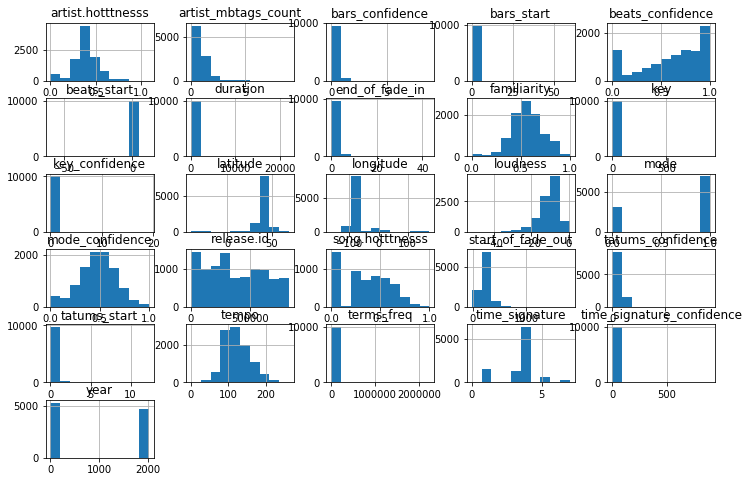

In [3]:
music_data = pd.read_csv('music.csv')
music_data.hist()
plt.show()

Now let's remove the columns we find extraneous to our dataset. Removing these columns will reduce the noise our classifier faces.

In [4]:
cols = [
    'artist.hotttnesss',
    'bars_start',
    'beats_start',
    'duration',
    'familiarity',
    'key',
    'loudness',
    'mode',
    'song.hotttnesss',
    'tatums_start',
    'tempo',
    'time_signature',
    'year'
]
music_data_dropped = music_data[cols]
music_data_dropped = music_data_dropped.fillna(0)

Now we can plot the distribution of data we have left.

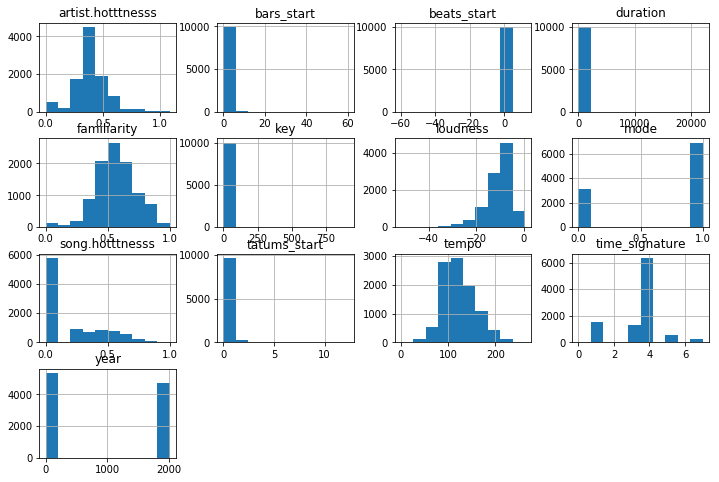

In [5]:
music_data_dropped.hist()
plt.show()

Now let's try to group by song hotness and see how our distributions line up

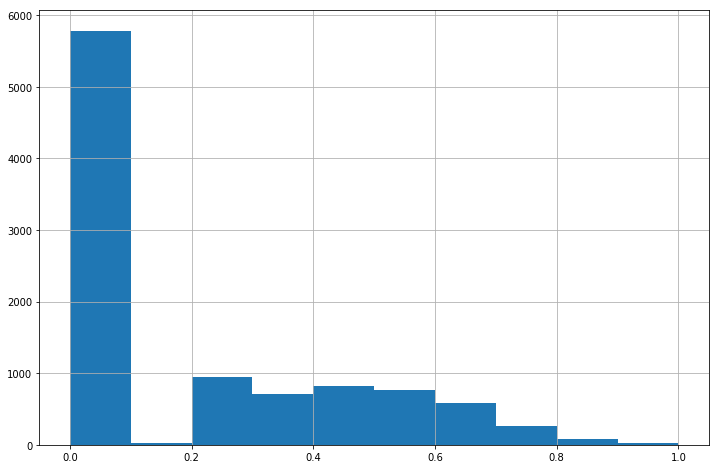

In [6]:
music_data_dropped['song.hotttnesss'].hist()

In [7]:
X = music_data_dropped.drop('song.hotttnesss', axis=1)  
y = music_data_dropped['song.hotttnesss']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

classifier = DecisionTreeRegressor(max_depth=12)
classifier.fit(X=X_train, y=y_train)

y_pred = classifier.predict(X_test)
classifier.score(X_test, y_test)

-0.004361208904181124

Now let's see how our classifier does by looking at actual vs predicted for a sample of the data

In [8]:
error_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
mean_absolute_error(y_test, y_pred)

0.17968240428019017

Now that we have a (pretty terribly) working classifier, let's try to experiment and improve our score

## Model Experiments

Let's first try writing some code to do 10-Fold cross validation

In [9]:
kf = KFold(n_splits=10)
kf.get_n_splits(music_data_dropped)

score_list = []
for i in xrange(1,20):
    current_fold_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        classifier = DecisionTreeRegressor(max_depth=i)
        classifier.fit(X=X_train, y=y_train)
        y_pred = classifier.predict(X_test)
        current_fold_scores.append(classifier.score(X_test, y_test))
    score_list.append(sum(current_fold_scores) / float(len(current_fold_scores)))

Now let's plot this vector and see how our MSE changes with the decision tree depth

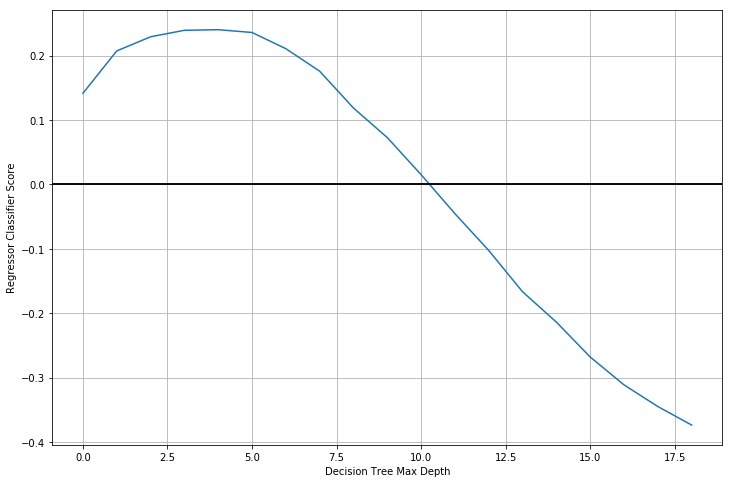

In [10]:
plt.plot(score_list)
plt.xlabel("Decision Tree Max Depth")
plt.ylabel("Regressor Classifier Score")
plt.axhline(0, color='black')
plt.axhline(0, color='black')
plt.grid()
plt.show()

In [11]:
kf = KFold(n_splits=10)
kf.get_n_splits(music_data_dropped)

score_list = []
for i in xrange(1,20):
    current_fold_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        classifier = DecisionTreeRegressor(max_depth=i)
        classifier.fit(X=X_train, y=y_train)
        y_pred = classifier.predict(X_test)
        current_fold_scores.append(mean_squared_error(y_test, y_pred))
    score_list.append(sum(current_fold_scores) / float(len(current_fold_scores)))

Now let's plot this vector and see how our score changes with the decision tree depth

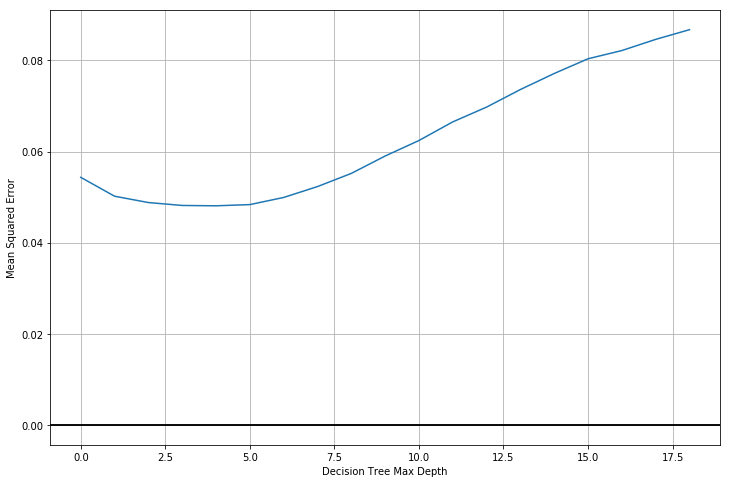

In [12]:
plt.plot(score_list)
plt.xlabel("Decision Tree Max Depth")
plt.ylabel("Mean Squared Error")
plt.axhline(0, color='black')
plt.axhline(0, color='black')
plt.grid()
plt.show()

# Preprocessing

Looking at our actual vs. predicted, it looks like a lot of our "Actuals" are 0, which is probably an erroneous input. Let's run everything again, but this time drop any rows that have a song.hotness of "0" or NaN

In [13]:
cols = [
    'artist.hotttnesss',
    'bars_start',
    'beats_start',
    'duration',
    'familiarity',
    'key',
    'loudness',
    'mode',
    'song.hotttnesss',
    'tatums_start',
    'tempo',
    'time_signature',
    'year'
]
music_data_dropped = music_data[cols]
music_data_dropped = music_data_dropped.dropna()
music_data_dropped = music_data_dropped[music_data_dropped['song.hotttnesss'] != 0.000000 ]

X2 = music_data_dropped.drop('song.hotttnesss', axis=1)  
y2 = music_data_dropped['song.hotttnesss']

new_music_df = music_data_dropped
new_music_df.shape

(4214, 13)

We've now incresed our Classifier Score by .1 for our test data

In [14]:
test_values = []
for j in xrange(1,20):    
    avg_list = []
    for i in xrange(10):
        kf = KFold(n_splits=10)
        kf.get_n_splits(new_music_df)

        new_X = new_music_df.drop('song.hotttnesss', axis=1)  
        new_y = new_music_df['song.hotttnesss']
        X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.10)

        classifier = DecisionTreeRegressor(max_depth=j)
        classifier.fit(X=X_train, y=y_train)

        y_pred = classifier.predict(X_test)
        avg_list.append(mean_squared_error(y_test, y_pred))
    test_values.append(sum(avg_list) / float(len(avg_list))) 

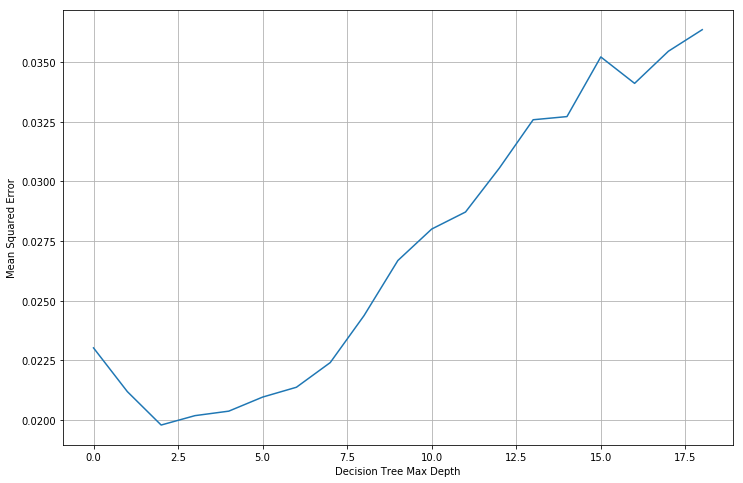

In [15]:
xlist = np.array(range(1,20))
test_values = np.array(test_values)
score_list = np.array(score_list)
plt.plot(test_values)
plt.xlabel("Decision Tree Max Depth")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

# Classification

Let's process our input data a bit more to see if we can use a Decision Tree classifier. We'll first start by deriving a column "hot?" that will be our binary classifier for each song (whether the hotness score is above the mean).

In [224]:
dt_music_data = music_data_dropped

In [233]:
hotness_mean = dt_music_data['song.hotttnesss'].mean()
hot_column = dt_music_data['song.hotttnesss'] > hotness_mean

X2 = dt_music_data.drop('song.hotttnesss', axis=1)  
y2 = hot_column

In [240]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.10)
classifier = DecisionTreeClassifier(max_depth=5)
classifier.fit(X=X_train, y=y_train)
y_pred = classifier.predict(X_test)

print "Accuracy Score: {}".format(accuracy_score(y_test, y_pred))
print confusion_matrix(y_test, y_pred)
print classification_report(y_test, y_pred)

Accuracy Score: 0.684834123223
[[142  66]
 [ 67 147]]
             precision    recall  f1-score   support

      False       0.68      0.68      0.68       208
       True       0.69      0.69      0.69       214

avg / total       0.68      0.68      0.68       422



By changing the input data to work with a Decision Tree Classifier, we already see a higher accuracy than Regression. Let's try to modify some of the parameters:

In [241]:
hotness_mean = dt_music_data['song.hotttnesss'].mean() * 1.5
hot_column = dt_music_data['song.hotttnesss'] > hotness_mean

X2 = dt_music_data.drop('song.hotttnesss', axis=1)  
y2 = hot_column

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.10)
classifier = DecisionTreeClassifier(max_depth=5)
classifier.fit(X=X_train, y=y_train)
y_pred = classifier.predict(X_test)

print "Accuracy Score: {}".format(accuracy_score(y_test, y_pred))
print confusion_matrix(y_test, y_pred)
print classification_report(y_test, y_pred)

Accuracy Score: 0.89336492891
[[371  14]
 [ 31   6]]
             precision    recall  f1-score   support

      False       0.92      0.96      0.94       385
       True       0.30      0.16      0.21        37

avg / total       0.87      0.89      0.88       422



By changing our success metric, we can correctly predict songs that are 1.5 * the mean with 90% accuracy.

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.10)
classifier = DecisionTreeClassifier(max_depth=6)
classifier.fit(X=X_train, y=y_train)
y_pred = classifier.predict(X_test)

print "Accuracy Score: {}".format(accuracy_score(y_test, y_pred))
print confusion_matrix(y_test, y_pred)
print classification_report(y_test, y_pred)

Accuracy Score: 0.890995260664
[[367  15]
 [ 31   9]]
             precision    recall  f1-score   support

      False       0.92      0.96      0.94       382
       True       0.38      0.23      0.28        40

avg / total       0.87      0.89      0.88       422

